*Exercise: Site Characteristics: The hub operator provided you with the data set, but has seemed to forget
 which site was supplying which data... Can you find out which of the two sites is the public one?
 Try to combine data understanding from previous descriptive analytics with domain knowledge
 (business understanding) of how private vs. public charging hubs might differ in operation. Explain
 your line of thought!*

**Site Considerations**
One of the two sites is public and situated next to a university, while the other is a private company site. One would expect that the private company site would reflect in its charging sessions unique patterns like charging durations similar to regular work days and weekly and diurnal concentrations on regular working times. The public site, on the other hand, would likely show more random patterns with less pronounced weekly and diurnal patterns. As shown in the two diagrams generated below, this is indeed the case. The first diagram shows the mean kWh delivered for each day of the week, with site two showing a slightly more uniform distribution across the days of the week, while site one shows a decent concentration on the regular working days. The second diagram shows the distribution of charging durations in 15-minute bins, with site two showing a more uniform distribution across the durations up to around ten hours, while site one shows a clear peak at around 9 to 10 hours, which is a typical workday duration, including breaks. Based on these observations, we can conclude that site one is the private company site and site two is the public university site.

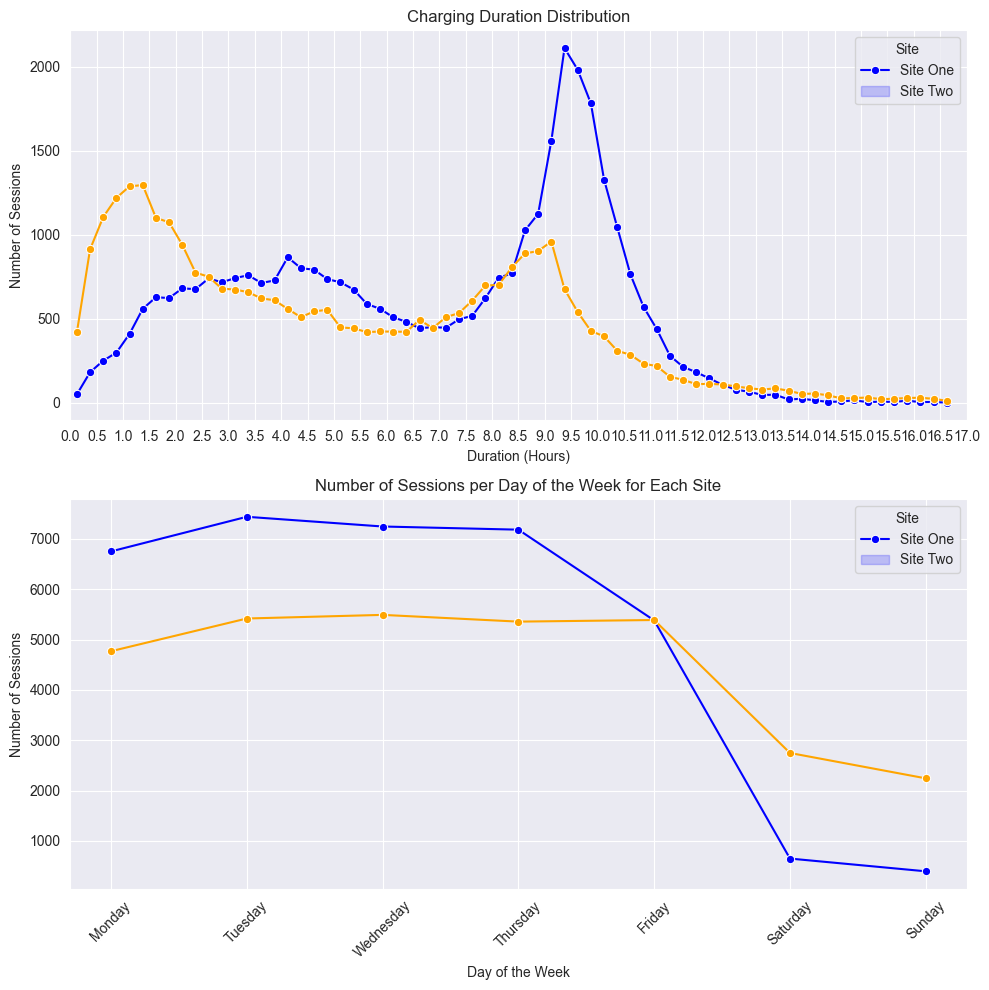

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

################################## Diagram 1 ##################################
# Load and preprocess data
df_diagram_one = pd.read_csv("../data/raw/charging_sessions.csv", parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])
df_diagram_one["duration"] = (df_diagram_one["disconnectTime"] - df_diagram_one["connectionTime"]).dt.total_seconds() / 60  # Convert duration to minutes

# Split by site
dfSiteOne = df_diagram_one.loc[df_diagram_one["siteID"] == 1].copy()  # Use .copy() to avoid SettingWithCopyWarning
dfSiteTwo = df_diagram_one.loc[df_diagram_one["siteID"] == 2].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Set up duration bins in 15-minute intervals
duration_bins = list(range(0, 1020, 15))  # Exclude outliers (duration > 17h)

# Bin the durations and calculate the count of sessions in each duration bin
dfSiteOne["duration_bin"] = pd.cut(dfSiteOne["duration"], bins=duration_bins, right=False)
dfSiteTwo["duration_bin"] = pd.cut(dfSiteTwo["duration"], bins=duration_bins, right=False)

# Calculate the number of sessions in each duration bin
site_one_duration_dist = dfSiteOne["duration_bin"].value_counts().sort_index()
site_two_duration_dist = dfSiteTwo["duration_bin"].value_counts().sort_index()

# Convert index to numeric for seaborn compatibility
site_one_duration_dist.index = site_one_duration_dist.index.categories.mid / 60
site_two_duration_dist.index = site_two_duration_dist.index.categories.mid / 60

###############################################################################


################################## Diagram 2 ##################################
# Load and preprocess data
df_diagram_2 = pd.read_csv("../data/processed/charging_sessions_cleaned.csv", parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

# Extract the day of the week from the connectionTime
df_diagram_2['dayOfWeek'] = df_diagram_2['connectionTime'].dt.day_name()

# Count sessions per siteID and day of the week
site_day_counts = df_diagram_2.groupby(['siteID', 'dayOfWeek']).size().reset_index(name='sessionCount')

# Ensure the days of the week are ordered correctly
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
site_day_counts['dayOfWeek'] = pd.Categorical(site_day_counts['dayOfWeek'], categories=order, ordered=True)

# Sort data by day of the week for proper plotting
site_day_counts = site_day_counts.sort_values(by='dayOfWeek')
###############################################################################


# Set up subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
palette = {1: "blue", 2: "orange"}

# Diagram 1: Duration Distribution in 15-Minute Bins with Hours on x-axis
sb.lineplot(x=site_one_duration_dist.index, y=site_one_duration_dist.values, label="Site One", marker="o", ax=axes[0], color=palette[1])
sb.lineplot(x=site_two_duration_dist.index, y=site_two_duration_dist.values, label="Site Two", marker="o", ax=axes[0], color=palette[2])
axes[0].set_xlabel("Duration (Hours)")
axes[0].set_ylabel("Number of Sessions")
axes[0].set_title("Charging Duration Distribution")
axes[0].legend(title="Site", labels=["Site One", "Site Two"])

# Adjust x-axis ticks to show hours in 0.25-hour increments
axes[0].set_xticks([i * 0.5 for i in range(int(1020 / 60 / 0.5) + 1)])  # Converts 1020 mins to hours with 0.25h steps
axes[0].set_xlim(0, 1020 / 60)  # Limit x-axis to 1020 minutes, converted to hours

# Diagram 2: Number of sessions per day of the week for each siteID
sb.lineplot(data=site_day_counts, x="dayOfWeek", y="sessionCount", hue="siteID", marker="o", ax=axes[1], palette=palette)
axes[1].set_title("Number of Sessions per Day of the Week for Each Site")
axes[1].set_xlabel("Day of the Week")
axes[1].set_ylabel("Number of Sessions")
axes[1].legend(title="Site", labels=["Site One", "Site Two"])
axes[1].set_xticks(range(len(order)))
axes[1].set_xticklabels(order, rotation=45)

plt.tight_layout()
plt.show()
